<a href="https://colab.research.google.com/github/shrutigadre5/StellarSort/blob/main/StellerSort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install numpy matplotlib seaborn pandas torch torchvision scikit-learn scikit-image skorch umap-learn h5py tqdm

First, we'll import some libraries that will be useful for later.

In [32]:
# Graphs and figures
import matplotlib.pyplot as plt
import seaborn as sns

# Data/arrays manipulation
import numpy as np
np.random.seed(0) # for reproducibility
import pandas as pd

# Machine learning !
import sklearn

# Part 1: ML on tabular data: star type classification
We will start with a very common use case: tabular data. We assume that we have a set of observations (rows) and that for each one we have a set of measurements or features (columns). In this case, we will work with a star catalogue of 240 stars described by the following information:

Temperature (in Kelvin)
Luminosity (L/Lo)
Radius (R/Ro)
Absolute magnitude (Mv)
We also have the following data for each star:

Color (Red/Orange/Yellow/White/Blue/…)
Spectral class ('A', 'B', 'F', 'G', 'K', 'M', 'O')
Star type (Brown dwarf/Red dwarf/White dwarf/Main sequence/Supergiant/Hypergiant)
This dataset has been collected by Deepraj Baidya and was originally published on Kaggle. Measurements were collected either from Wikipedia or derived from the laws of physics.

# Objective
We want to build a decisional model to help us categorize stars based on their observed properties. Mathematically, this means that we want to build a classification function that outputs:

f:(x1,x2,...,xn)∈Rn→f(x1,...,xn)=y∈{0,1,2,...,k−1}, where:

(x1,...,xn) represent the features (i.e. the observed physical properties),
y represents the index of the class (i.e. the star type).
This is a toy example but that will be helpful to demonstrate some core concepts from machine learning.

In [33]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")

('stars.csv', <http.client.HTTPMessage at 0x785c5c8b0450>)

In [34]:
df_stars = pd.read_csv("stars.csv")

The dataset is comprised of 240 stars and their properties. Looking at the data, we can see that some of the variables are continuous values (e.g. temperature) while others are categorical (color and class).


In [35]:
df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


Our goal with this dataset is try to learn a statistical that infers the star type based on its physical properties. There are 6 star types that are encoded in the 'Star type' column. We call this information the labels.

The labels are currently encoded as strings which is practical for reading but not for computing. Using scikit-learn, we will convert this column into integers by assigning a unique int value to each star type. The LabelEncoder object is used to convert from a set of values to integers.

In [36]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
class_names = le.classes_
print(class_names)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']


In [37]:
labels = le.inverse_transform(df_stars['Star type'])

We want to build a statistical model that learns how to map Temperature/Luminosity/Radius/Absolute magnitude to the star type. Since the labels are categorical, this task is called classification.

We will use a supervised approach: we build a model by training it on some examples for which we know the actual labels (the ground truth). Then, we will try to see if the model can infer the right star type on new data that it has not seen during training.

# Preliminary analysis

It is often grood practice to start with a statistical analysis of the dataset to answer the following questions:

* Are there any missing values?
* Are there NaNs in the data?
* Are some variables redundant (i.e. strongly correlated)?
* Is the data distribution skewed somehow?

We can start by plotting the correlations between variables:

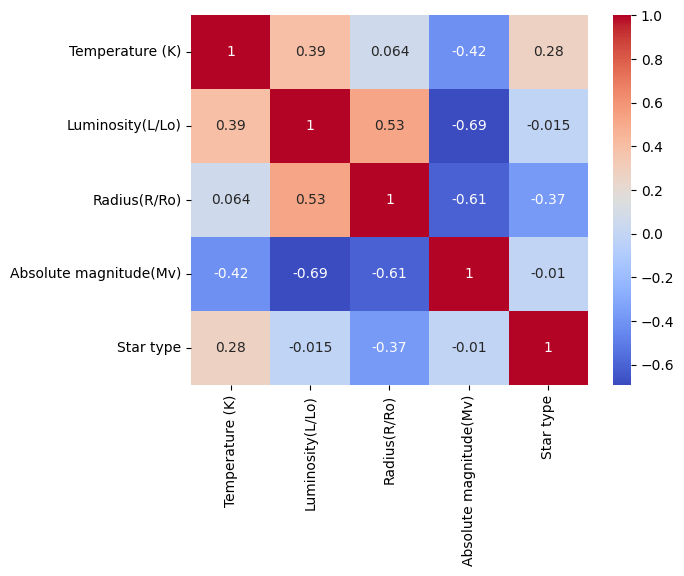

In [38]:
# Select only numeric columns for correlation
numeric_df = df_stars.select_dtypes(include=['number'])

# Compute and visualize the correlation matrix
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.show()

Star classification is something that can be done based on rules depending on temperature and luminosity. For example, Wikipedia gives the following example of a Hertzsprung-Russell diagram:

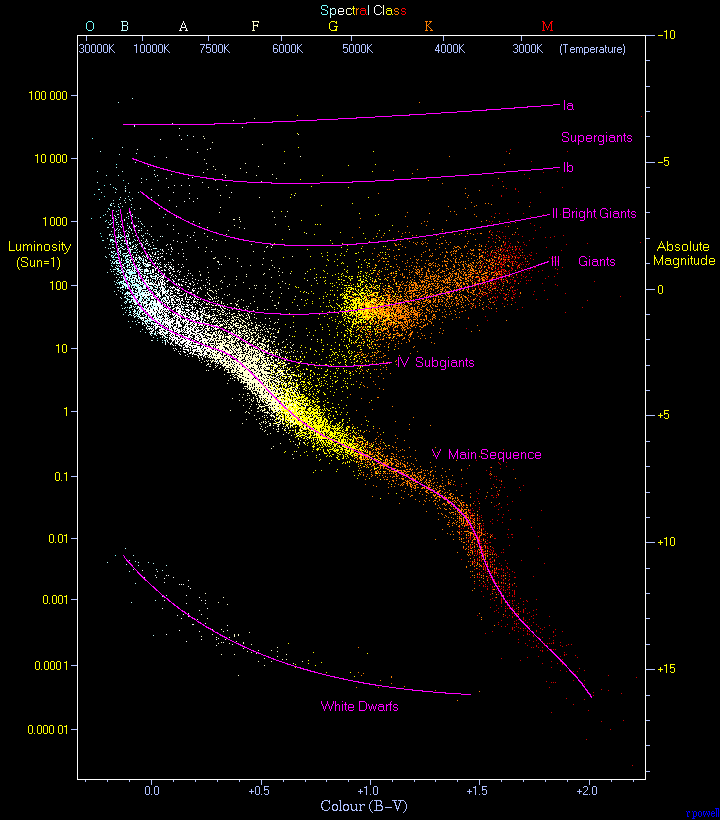

We can reproduce this diagram by plotting the scatter plot of our stars using the same variables in log-log-scale.

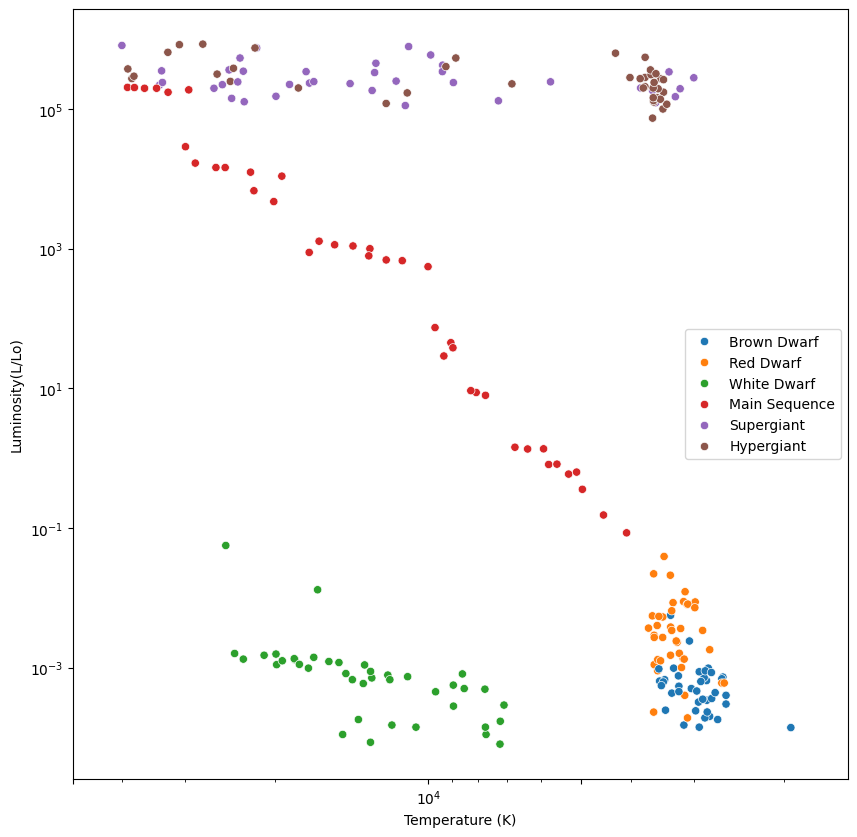

In [39]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)
plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

##**Dimension reduction**

A first common step for data analysis is dimension reduction to reduce the number of features (column variables) in the dataset. There are two main uses for dimension reduction algorithms:

1. visualization by reducing the number of variables to 2 or 3
2. reducing the number of variables for easier data mining (e.g. fighting the curse of dimensionality)

A well-known dimension reduction algorithm is the **Principal Component Analysis** (PCA). PCA finds linear combinations of variables that explain most of the variance in the data.

scikit-learn offers a PCA module that is straightforward to use. Nearly all statistical models implemented in sklearn follow the same interface. Let's start by importing the module.

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

By default, the PCA() object performs a full decomposition with as many components as there are input variables. However in this case we will perform a PCA for visualization using a 2D point cloud, so we can keep only the first 2 principal components.

Performing the actual PCA is done using the .fit() method on the data. We will keep only the physical measurements for this analysis. PCA is unsupervised, which means the model depends only the observations (and it does not require labels).

In [41]:
df_stars_data = df_stars.drop(columns=["Star color", "Star type", "Spectral Class"])
X = np.array(df_stars_data)

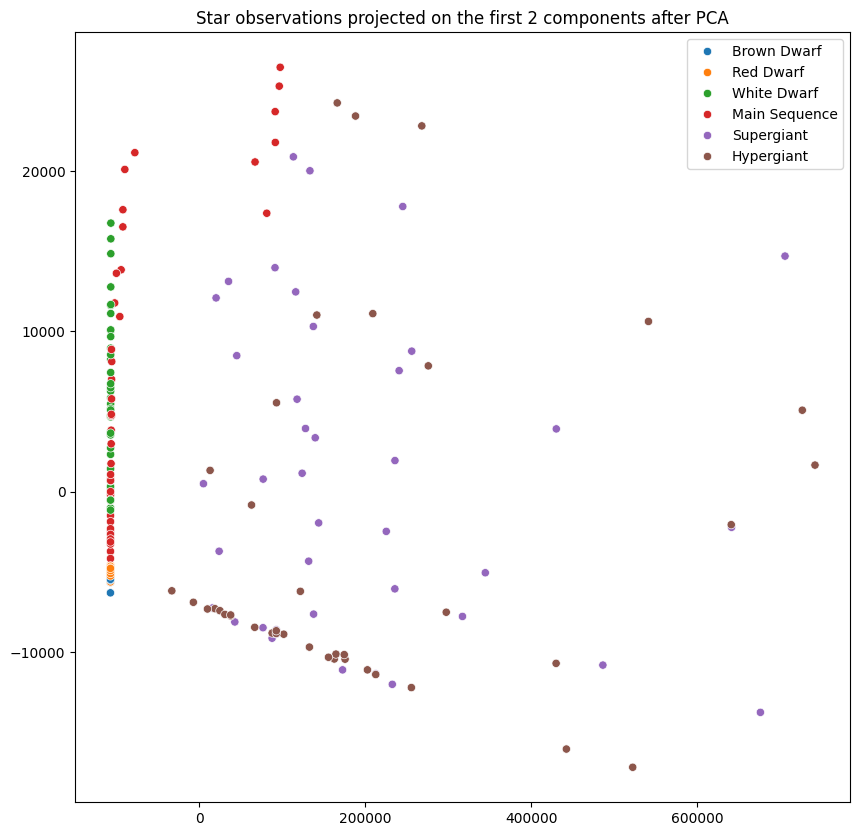

In [42]:
projected_stars = pca.fit_transform(X)

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x=projected_stars[:,0], y=projected_stars[:,1], hue=labels)
plt.title("Star observations projected on the first 2 components after PCA")
plt.show()

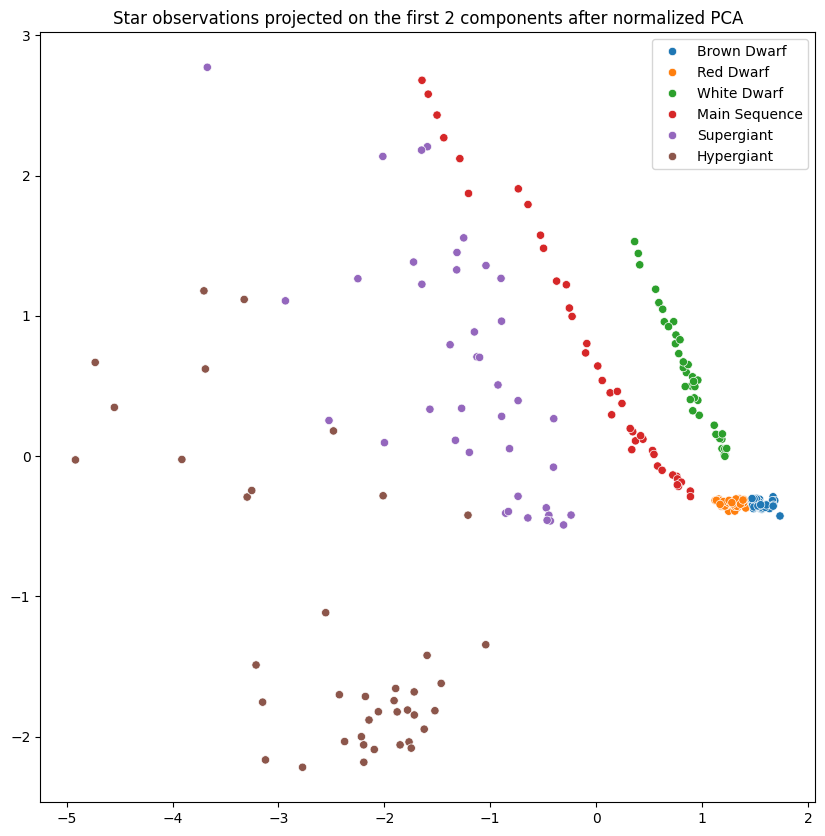

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(df_stars_data)

pca = PCA()
projected_stars = pca.fit_transform(X)

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x=projected_stars[:,0], y=projected_stars[:,1], hue=labels)
plt.title("Star observations projected on the first 2 components after normalized PCA")
plt.show()

In [44]:
s = 0
for idx, r in enumerate(pca.explained_variance_ratio_):
    s += r
    print(f"Component {idx+1} explains {100*r:.1f}% of the variance (cumulative = {100*s:.1f})")

Component 1 explains 60.4% of the variance (cumulative = 60.4)
Component 2 explains 23.5% of the variance (cumulative = 83.9)
Component 3 explains 9.3% of the variance (cumulative = 93.2)
Component 4 explains 6.8% of the variance (cumulative = 100.0)


# Model selection : train/test split and cross-validation

## Decision tree

Decision trees are very common in machine learning. Their strong suit is their interpetability: it is easy to understand a posteriori why the model predicted type A instead of type B. Decision trees are implemented in sklearn in the tree module.

In [49]:
from sklearn.model_selection import train_test_split
stars_train, stars_test = train_test_split(df_stars.drop(columns=["Star color", "Spectral Class"]), train_size=0.2)

In [50]:
X_train, y_train = stars_train.drop(columns="Star type"), stars_train["Star type"]
X_test, y_test = stars_test.drop(columns="Star type"), stars_test["Star type"]

In [51]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

In [53]:
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [54]:
tree.predict(X_test)

array([2, 1, 2, 2, 1, 3, 2, 1, 1, 3, 1, 4, 3, 0, 5, 5, 3, 2, 5, 2, 0, 2,
       0, 2, 3, 1, 4, 3, 4, 3, 1, 3, 4, 1, 0, 4, 3, 5, 1, 4, 4, 0, 1, 1,
       0, 2, 3, 0, 1, 4, 3, 3, 5, 4, 1, 5, 4, 3, 1, 2, 0, 2, 3, 1, 3, 5,
       1, 2, 5, 1, 2, 0, 1, 3, 0, 3, 1, 0, 5, 0, 1, 2, 2, 0, 0, 4, 1, 0,
       3, 1, 5, 1, 4, 4, 3, 0, 5, 3, 2, 1, 1, 5, 0, 5, 4, 2, 4, 2, 2, 1,
       4, 4, 1, 1, 3, 5, 4, 4, 4, 0, 3, 1, 5, 3, 0, 2, 0, 5, 4, 4, 0, 5,
       0, 5, 4, 3, 2, 3, 0, 2, 5, 5, 1, 3, 0, 3, 5, 0, 4, 3, 5, 1, 3, 5,
       2, 4, 3, 0, 0, 4, 5, 3, 5, 5, 2, 1, 5, 4, 2, 3, 5, 2, 2, 2, 4, 4,
       5, 1, 0, 1, 4, 5, 4, 0, 0, 5, 3, 5, 2, 5, 2, 1])

In [55]:
tree.score(X_test, y_test)

1.0

Great! Our model reaches almost 100% accuracy on the test set. Well, the dataset is fairly easy. :-)

Knowing how many stars have been accurately classified is good but for a more detailed analysis, we can turn to the confusion matrix. The confusion matrix indicates for each actual star type (rows) how the stars of this group have been predicted (columns).

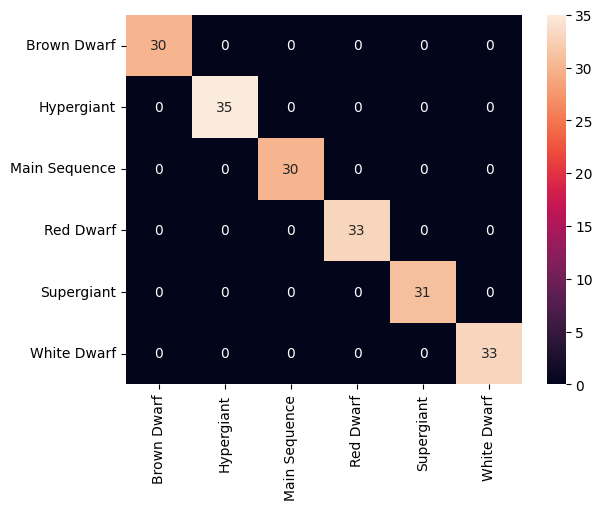

In [56]:
from sklearn.metrics import confusion_matrix

y_pred = tree.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.show()

We can now see that the 35 brown dwarves of the test dataset have all been correctly predicted as brown dwarves. However, 8 stars from the Main Sequence have been classified as Red Dwarfs.

As said before, one big advantage of decision trees is that they are easy to interpret. For example, you can draw the full decision tree to understand the different tests that are made before taking the final decision:

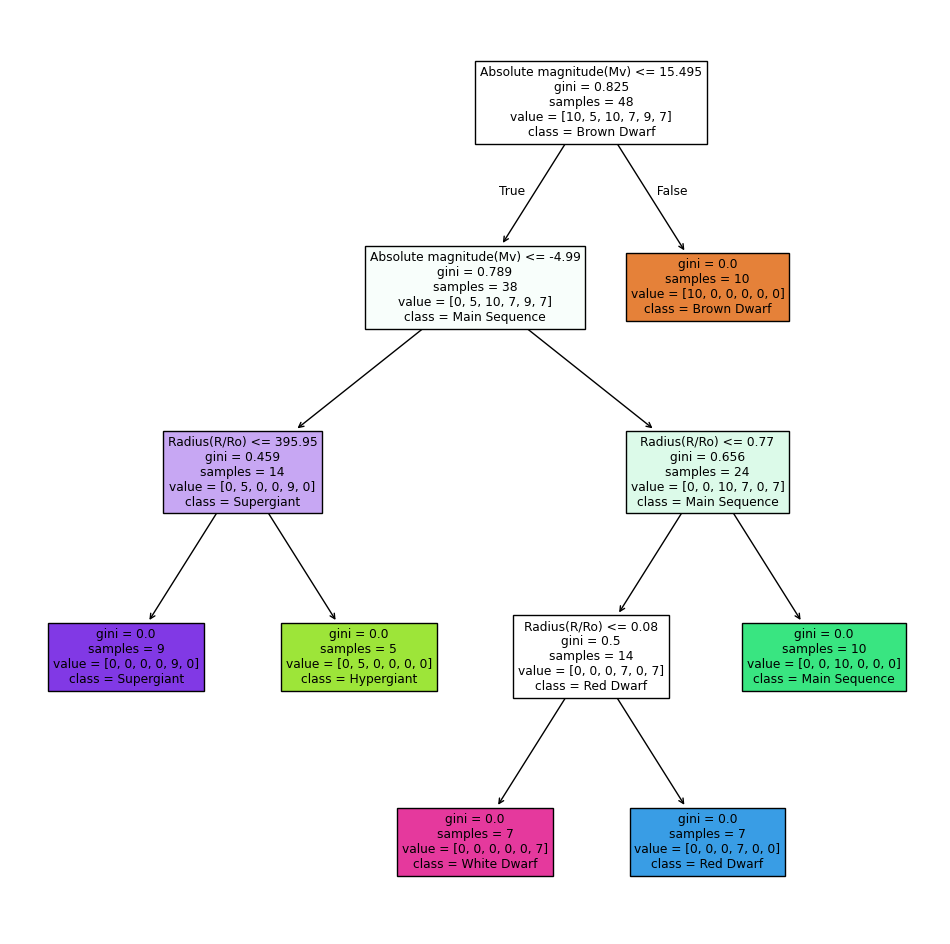

In [57]:
fig = plt.figure(figsize=(12, 12))
sklearn.tree.plot_tree(tree, filled=True, feature_names=stars_train.drop(columns="Star type").keys(), class_names=class_names)
plt.show()

# SVM
Now, decision trees are nice but they are fairly simple models. In the shallow ML world, Support Vector Machines (SVM) are all the rage. But do I have to rewrite all my code to use them? Nope! All models in scikit-learn have the same interface so you can just swap your DecisionTree with a SVC (Support Vector Classifier).

Check this out:

In [58]:
from sklearn.svm import SVC
scaler2 = StandardScaler()
X_train_s = scaler2.fit_transform(X_train)
X_test_s = scaler2.transform(X_test)
svm = SVC()
svm.fit(X_train_s, y_train)
svm.score(X_test_s, y_test)

0.796875

Great. However there is one little problem: the SVM is underperforming very badly the decision tree. Why? We let sklearn use the default parameters in the SVC(). There are various parameters that you can use in an SVM. The two main ones are:

the kernel (by default, scikit-learn uses a linear SVM, fast but not great. We often use a RBF kernel, slower but more powerful.)
the regularization parameter C (it controls how "smooth" the decision border is).
So for example, I can ask for an SVM with a polynomial kernel of degree 4 and C=100 using:

In [59]:
svm = SVC(C=100, kernel='poly', degree=4)
svm.fit(X_train_s, y_train)
svm.score(X_test_s, y_test)

0.9791666666666666

In [60]:
from sklearn.model_selection import GridSearchCV

grid = {'C': [1e-2, 0.1, 1.0, 10, 100, 1000, 10000], 'kernel': ['linear', 'rbf'], 'gamma': ['auto', 'scale']}
model = GridSearchCV(SVC(), grid)
model.fit(X_train_s, y_train)
model.score(X_test_s, y_test)

0.96875

In [61]:
model.best_params_

{'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}

# Part 2: ML on image data

Let's move on to a harder problem. We have seen how to perform machine learning on tabular data, i.e. 1-dimensional data. Tabular data is often structured, meaning that the columns are known to be significant in a way or the other. The raw information has already been processed and synthesized in a catalogue.

But what if we want to go back the source? Computer vision provides a diverse set of tools taken from both image processing and machine learning that can help to perform data mining in large collections of image.

In [62]:
import urllib.request
urllib.request.urlretrieve("http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5", "Galaxy10.h5")

('Galaxy10.h5', <http.client.HTTPMessage at 0x785c5c3d2610>)

In [63]:
import numpy as np
import h5py

# Images and labels are stored in HDF5 format but we could use flat files instead
with h5py.File('Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'], dtype='int64')

print(f"Galaxy10 dataset: {len(images)} images and {len(np.unique(labels))} classes")

Galaxy10 dataset: 21785 images and 10 classes


We are dealing with 69x69 color images of galaxies. The goal of the Galaxy10 dataset is perform classification of these images into one of the 10 galaxy shapes defined hereafter:

In [64]:
class_names = [
    "Disk, Face-on, No Spiral",
    "Smooth, Completely round",
    "Smooth, in-between round",
    "Smooth, Cigar shaped",
    "Disk, Edge-on, Rounded Bulge",
    "Disk, Edge-on, Boxy Bulge",
    "Disk, Edge-on, No Bulge",
    "Disk, Face-on, Tight Spiral",
    "Disk, Face-on, Medium Spiral",
    "Disk, Face-on, Loose Spiral"
]

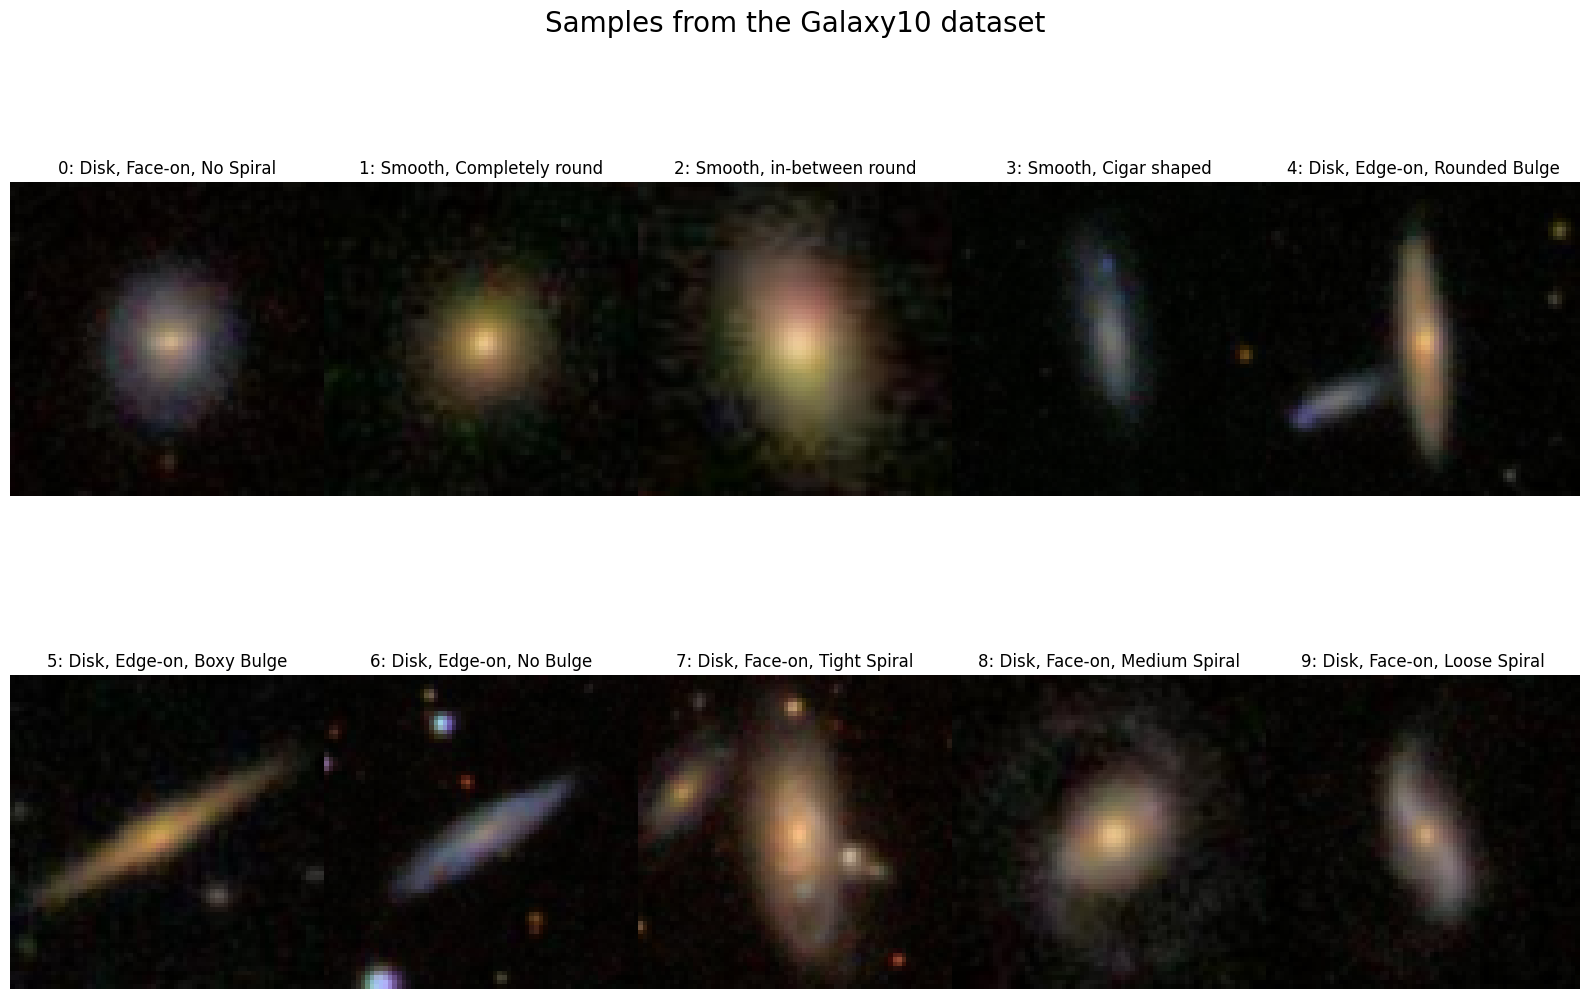

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

_, demo_idx = np.unique(labels, return_index=True)

fig = plt.figure(figsize=(16, 12))
for idx, (img, label) in enumerate(zip(images[demo_idx], labels[demo_idx])):
    fig.add_subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{label}: {class_names[label]}")
fig.tight_layout(h_pad=0, w_pad=0)
plt.suptitle("Samples from the Galaxy10 dataset", fontsize=20)
plt.show()